# Notebook Ilustrating a Benchmark HH Neuron to be used with Model Fitting

In [17]:
from brian2 import *
from brian2tools import *

import matplotlib.pyplot as plt
%matplotlib inline
prefs.codegen.target = 'cython'  # weave is not multiprocess-safe!


## HH Example

In [2]:
area = 20000*umetre**2

In [3]:
# Generate a step-current input and an "experimental" voltage trace
dt = 0.01*ms
input_current = np.hstack([np.zeros(int(5*ms/dt)), np.ones(int(5*ms/dt)), np.zeros(int(5*ms/dt))])*nA

In [4]:
N, n1 = np.array([input_current]).shape

In [5]:

params = {'gl': float(5e-5*siemens*cm**-2 * area),
          'g_na': float(100*msiemens*cm**-2 * area),
          'g_kd': float(30*msiemens*cm**-2 * area)}
print ('"correct" parameters:', params)

"correct" parameters: {'gl': 1e-08, 'g_na': 2e-05, 'g_kd': 6e-06}


In [6]:
input_current.shape

(1497,)

In [7]:
# Parameters
Cm = 1*ufarad*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
VT = -63*mV
gl = 5e-5*siemens*cm**-2 * area,
g_kd = 30*msiemens*cm**-2 * area,

defaultclock.dt = dt
I = TimedArray(input_current, dt=dt)

In [8]:
# The model
eqs = Equations('''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I(t))/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
g_na : siemens (constant)
g_kd : siemens (constant)
gl   : siemens (constant)
''')

G = NeuronGroup(1, eqs, method='exponential_euler')
G.v = El
G.set_states(params, units=False)
mon = StateMonitor(G, 'v', record=0)
run(20*ms)

In [9]:
voltage = mon.v[0]/mV

In [10]:
voltage += np.random.randn(len(voltage))

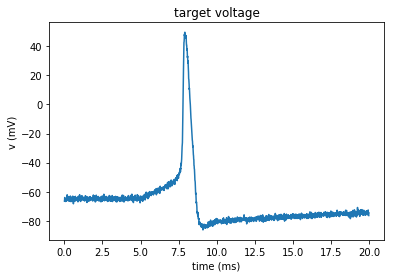

In [11]:
plot(np.arange(len(voltage))*dt/ms, voltage); 
title('target voltage'); xlabel('time (ms)'); ylabel('v (mV)');

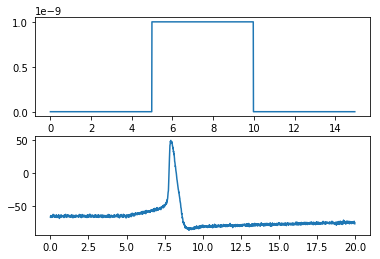

In [12]:
fig, ax = plt.subplots(2,1)
ax[0].plot(np.arange(len(I.values))*dt/ms, I.values);
ax[1].plot(np.arange(len(voltage))*dt/ms, voltage); 

In [13]:
inp_trace = np.array([input_current])
n0, n1 = inp_trace.shape
inp_trace.shape

(1, 1497)

In [14]:
out_trace = np.array([voltage[:n1]])
out_trace.shape

(1, 1497)

## brian2tools version 

In [15]:
# params = {'gl': float(5e-5*siemens*cm**-2 * area),
#           'g_na': float(100*msiemens*cm**-2 * area),
#           'g_kd': float(30*msiemens*cm**-2 * area)}

In [18]:
params, fits, error = fit_traces(model = eqs, input_var = 'I', output_var = 'v',\
        input = inp_trace * nA, output = out_trace*mV, dt = dt,
        gl = [1e-09, 1e-07],
        g_na  = [1e-07, 1e-03],
        g_kd = [1e-08, 1e-04], 
        tol = 1e-6, popsize=10)

input [[0. 0. 0. ... 0. 0. 0.]] A
params: [[2.36483361e-04 8.66552731e-08 4.23223930e-05]
 [3.37890639e-04 1.03912456e-08 1.39410220e-05]
 [1.67253813e-04 7.34032720e-08 8.45996869e-05]
 [7.97675265e-04 4.24377782e-08 9.87332760e-05]
 [1.95237188e-05 5.60882651e-08 6.70264746e-05]
 [8.08088093e-04 5.12156885e-08 3.01349011e-06]
 [2.82658678e-04 9.07298386e-08 3.20161973e-05]
 [5.35581547e-04 7.60326309e-08 6.16175091e-05]
 [3.16799604e-04 3.68825869e-08 9.63386927e-05]
 [8.38094582e-04 1.99145914e-08 3.80203284e-05]
 [6.85498259e-04 2.80371940e-08 8.80984640e-05]
 [7.64964405e-04 2.55914462e-08 5.10102289e-05]
 [7.61686774e-05 6.14994585e-08 7.59524034e-05]
 [4.95747833e-04 4.96855023e-08 6.58546680e-06]
 [9.57821957e-04 2.37881945e-08 2.84128813e-05]
 [4.62030030e-04 1.55817351e-08 8.10401345e-05]
 [1.45071081e-04 8.77235017e-08 2.54982590e-05]
 [5.20411986e-04 6.02186790e-08 4.86935810e-05]
 [3.86638649e-04 3.10490423e-08 1.83850767e-05]
 [6.00267821e-04 3.95324195e-08 5.62855120e-05

BrianObjectException: Original error and traceback:
Traceback (most recent call last):
  File "/home/alteska/Desktop/brian/brian2/build/lib.linux-x86_64-3.7/brian2/parsing/bast.py", line 129, in render_node
    return getattr(self, methname)(node)
  File "/home/alteska/Desktop/brian/brian2/build/lib.linux-x86_64-3.7/brian2/parsing/bast.py", line 190, in render_Call
    for subnode, argtype in zip(node.args, funcvar._arg_types):
AttributeError: 'Subexpression' object has no attribute '_arg_types'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/alteska/Desktop/brian/brian2/build/lib.linux-x86_64-3.7/brian2/core/network.py", line 864, in before_run
    obj.before_run(run_namespace)
  File "/home/alteska/Desktop/brian/brian2/build/lib.linux-x86_64-3.7/brian2/groups/group.py", line 1128, in before_run
    codeobj_class=self.codeobj_class
  File "/home/alteska/Desktop/brian/brian2/build/lib.linux-x86_64-3.7/brian2/codegen/codeobject.py", line 309, in create_runner_codeobj
    _, uk, u = analyse_identifiers(v, all_variables, recursive=True)
  File "/home/alteska/Desktop/brian/brian2/build/lib.linux-x86_64-3.7/brian2/codegen/translation.py", line 94, in analyse_identifiers
    scalar_stmts, vector_stmts = make_statements(code, variables, np.float64, optimise=False)
  File "/home/alteska/Desktop/brian/brian2/build/lib.linux-x86_64-3.7/brian2/utils/caching.py", line 100, in cached_func
    func._cache[cache_key] = func(*args, **kwds)
  File "/home/alteska/Desktop/brian/brian2/build/lib.linux-x86_64-3.7/brian2/codegen/translation.py", line 236, in make_statements
    annotated_ast = brian_ast(expr, variables)
  File "/home/alteska/Desktop/brian/brian2/build/lib.linux-x86_64-3.7/brian2/parsing/bast.py", line 112, in brian_ast
    return renderer.render_node(node)
  File "/home/alteska/Desktop/brian/brian2/build/lib.linux-x86_64-3.7/brian2/parsing/bast.py", line 129, in render_node
    return getattr(self, methname)(node)
  File "/home/alteska/Desktop/brian/brian2/build/lib.linux-x86_64-3.7/brian2/parsing/bast.py", line 209, in render_BinOp
    node.left = self.render_node(node.left)
  File "/home/alteska/Desktop/brian/brian2/build/lib.linux-x86_64-3.7/brian2/parsing/bast.py", line 129, in render_node
    return getattr(self, methname)(node)
  File "/home/alteska/Desktop/brian/brian2/build/lib.linux-x86_64-3.7/brian2/parsing/bast.py", line 210, in render_BinOp
    node.right = self.render_node(node.right)
  File "/home/alteska/Desktop/brian/brian2/build/lib.linux-x86_64-3.7/brian2/parsing/bast.py", line 129, in render_node
    return getattr(self, methname)(node)
  File "/home/alteska/Desktop/brian/brian2/build/lib.linux-x86_64-3.7/brian2/parsing/bast.py", line 209, in render_BinOp
    node.left = self.render_node(node.left)
  File "/home/alteska/Desktop/brian/brian2/build/lib.linux-x86_64-3.7/brian2/parsing/bast.py", line 131, in render_node
    raise SyntaxError("Unknown syntax: " + nodename)
  File "<string>", line None
SyntaxError: Unknown syntax: Call

Error encountered with object named "neurongroup_2_run_regularly_1".
Object was created here (most recent call only, full details in debug log):
  File "/home/alteska/Desktop/brian/brian2tools/brian2tools/modelfitting/modelfitting.py", line 132, in fit_traces
    neurons.run_regularly(state_update_code, when='groups')

An error occurred when preparing an object.   File "<string>", line None

SyntaxError: Unknown syntax: Call
(See above for original error message and traceback.)